In [1]:

import os
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
import scipy.spatial.distance as dist
import catboost as cbt
import json
from sklearn.metrics import f1_score
import time

import gc
import math
from tqdm import tqdm
from scipy import stats
from sklearn.cluster import KMeans
from six.moves import reduce
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

In [2]:
os.listdir(r'H:\compitition\zhengxinfusai')
submission = pd.read_csv(r'H:\compitition\zhengxinfusai\submission.csv')
train = pd.read_csv(r'H:\compitition\zhengxinfusai/0416/train0416.csv')
test = pd.read_csv(r'H:\compitition\zhengxinfusai/0416/test0416.csv')



In [3]:
data = train.append(test)

D:\A\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
data.shape

(23944, 257)

In [6]:
data_feat = ['注销时间','经营期限自','成立日期','核准日期','经营期限至']

In [7]:
object_col = [i for i in data.select_dtypes(float).columns if i not in ['ID','Label']]
for i in tqdm(object_col):
    lbl = LabelEncoder()
    data[i] = lbl.fit_transform(data[i].astype(str))


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:06<00:00, 40.33it/s]


In [8]:
cat_list = [i for i in train.columns if i in ['企业类型', '登记机关', '邮政编码', '企业状态', '行业代码', '行业门类', '企业类别', '管辖机关', '纳税人状态代码', '登记注册类型代码']]

In [9]:
feature_name = [i for i in data.columns if i not in ['ID', 'Label']]


In [10]:
tr_index = ~data['Label'].isnull()
X_train = data[tr_index][list(set(feature_name))].reset_index(drop=True)
y = data[tr_index]['Label'].reset_index(drop=True).astype(int)
X_test = data[~tr_index][list(set(feature_name))].reset_index(drop=True)
print(X_train.shape,X_test.shape)
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
seeds = [19970412, 2019 * 2 + 1024, 4096, 2018, 1024]
num_model_seed = 5
for model_seed in range(num_model_seed):
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat=np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=5, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        print(index)
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        cbt_model = cbt.CatBoostClassifier(iterations=8000,learning_rate=0.08,max_depth=8,verbose=100,
                                       early_stopping_rounds=500,task_type='GPU',eval_metric='F1',
                                       cat_features=cat_list)
        cbt_model.fit(train_x[feature_name], train_y,eval_set=(test_x[feature_name],test_y))
        gc.collect()    
        oof_cat[test_index] += cbt_model.predict_proba(test_x)[:,1]
        prediction_cat += cbt_model.predict_proba(X_test[feature_name])[:,1]/5
    print('F1',f1_score(y, np.round(oof_cat)))    
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
print('score',f1_score(y, np.round(oof))) 

(14366, 255) (9578, 255)
0
0:	learn: 0.9022842	test: 0.8821781	best: 0.8821781 (0)	total: 213ms	remaining: 28m 26s
100:	learn: 0.9747464	test: 0.9178653	best: 0.9181727 (75)	total: 19.8s	remaining: 25m 47s
200:	learn: 0.9865132	test: 0.9207098	best: 0.9211729 (179)	total: 40s	remaining: 25m 52s
300:	learn: 0.9923230	test: 0.9220281	best: 0.9223276 (291)	total: 1m	remaining: 25m 37s
400:	learn: 0.9949763	test: 0.9227257	best: 0.9228538 (375)	total: 1m 20s	remaining: 25m 16s
500:	learn: 0.9963886	test: 0.9232942	best: 0.9235474 (482)	total: 1m 40s	remaining: 24m 59s
600:	learn: 0.9975287	test: 0.9233238	best: 0.9236194 (580)	total: 2m	remaining: 24m 47s
700:	learn: 0.9983136	test: 0.9238115	best: 0.9242647 (669)	total: 2m 20s	remaining: 24m 26s
800:	learn: 0.9990086	test: 0.9247672	best: 0.9248697 (757)	total: 2m 41s	remaining: 24m 8s
900:	learn: 0.9992999	test: 0.9241603	best: 0.9248933 (813)	total: 3m 1s	remaining: 23m 52s
1000:	learn: 0.9995373	test: 0.9237937	best: 0.9248933 (813)	to

Shrink model to first 19 iterations.
1
0:	learn: 0.9028928	test: 0.8999029	best: 0.8999029 (0)	total: 178ms	remaining: 23m 44s
100:	learn: 0.9765640	test: 0.9175730	best: 0.9183674 (89)	total: 19.7s	remaining: 25m 39s
200:	learn: 0.9882540	test: 0.9184853	best: 0.9186774 (199)	total: 39.4s	remaining: 25m 29s
300:	learn: 0.9927076	test: 0.9189191	best: 0.9205198 (235)	total: 59.4s	remaining: 25m 19s
400:	learn: 0.9951302	test: 0.9192302	best: 0.9205198 (235)	total: 1m 19s	remaining: 25m 4s
500:	learn: 0.9969551	test: 0.9203534	best: 0.9206942 (498)	total: 1m 39s	remaining: 24m 44s
600:	learn: 0.9977700	test: 0.9197789	best: 0.9206942 (498)	total: 1m 58s	remaining: 24m 24s
700:	learn: 0.9983271	test: 0.9192598	best: 0.9206942 (498)	total: 2m 18s	remaining: 24m 4s
800:	learn: 0.9987742	test: 0.9185289	best: 0.9206942 (498)	total: 2m 39s	remaining: 23m 53s
900:	learn: 0.9991015	test: 0.9184298	best: 0.9206942 (498)	total: 2m 59s	remaining: 23m 34s
bestTest = 0.9206941724
bestIteration = 49

500:	learn: 0.9927651	test: 0.9181525	best: 0.9201533 (7)	total: 1m 38s	remaining: 24m 30s
bestTest = 0.9201533198
bestIteration = 7
Shrink model to first 8 iterations.
F1 0.1576182136602452
0
0:	learn: 0.9136532	test: 0.9091691	best: 0.9091691 (0)	total: 182ms	remaining: 24m 16s
100:	learn: 0.9727771	test: 0.9197285	best: 0.9215197 (11)	total: 19.5s	remaining: 25m 24s
200:	learn: 0.9874507	test: 0.9215966	best: 0.9219966 (184)	total: 39.8s	remaining: 25m 43s
300:	learn: 0.9919482	test: 0.9230725	best: 0.9232656 (299)	total: 1m	remaining: 25m 40s
400:	learn: 0.9946694	test: 0.9228617	best: 0.9236223 (339)	total: 1m 20s	remaining: 25m 17s
500:	learn: 0.9960665	test: 0.9237760	best: 0.9241189 (486)	total: 1m 39s	remaining: 24m 52s
600:	learn: 0.9970371	test: 0.9235356	best: 0.9241189 (486)	total: 1m 59s	remaining: 24m 29s
700:	learn: 0.9978140	test: 0.9241130	best: 0.9245701 (628)	total: 2m 19s	remaining: 24m 7s
800:	learn: 0.9987078	test: 0.9244007	best: 0.9249820 (737)	total: 2m 38s	re

<BarContainer object of 255 artists>

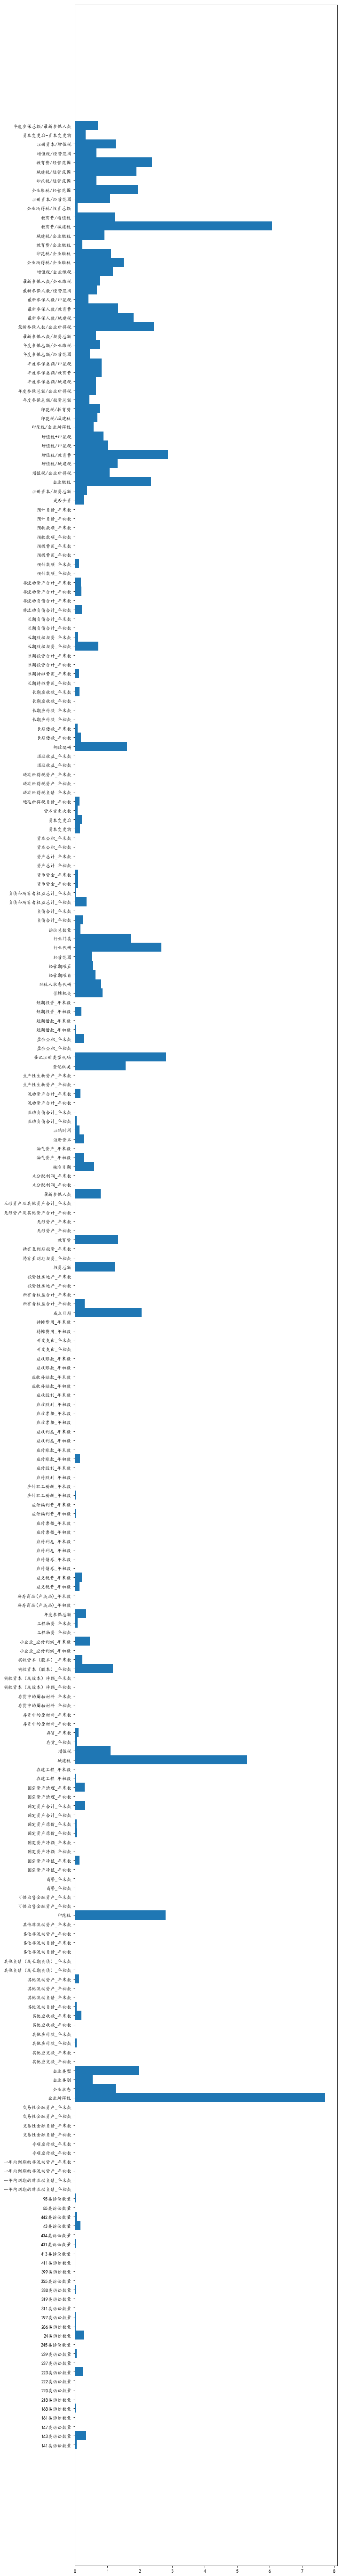

In [11]:
import matplotlib.pyplot as plt 


plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

fea_ = cbt_model.feature_importances_
fea_name = cbt_model.feature_names_
plt.figure(figsize=(10, 100))
plt.barh(fea_name,fea_,height =1)

In [12]:

submission['Label'] = prediction

submission.to_csv("submission0416cat.csv",index=False)

In [24]:
cbt_model.feature_importances_

array([1.53938836e+00, 1.70017926e+00, 1.14202043e+00, 1.38282150e+00,
       5.32442286e-01, 4.13254942e-01, 9.91906751e-02, 1.66378340e+00,
       6.77129219e-01, 9.49501700e-01, 3.22480052e+00, 1.63287563e+00,
       7.45162413e-01, 8.72022038e-01, 1.91782811e+00, 1.13900764e+00,
       2.29257981e+00, 1.79427976e+00, 5.53929522e-01, 1.82050900e+00,
       3.00574985e-02, 0.00000000e+00, 1.78603706e-01, 4.05709525e-01,
       7.11119141e-02, 2.89896605e-02, 1.69704575e-01, 3.91014426e-03,
       1.46172406e-02, 0.00000000e+00, 1.14417890e-02, 1.66127593e-02,
       0.00000000e+00, 5.08129726e-02, 7.51965100e-02, 0.00000000e+00,
       2.85253949e-01, 6.32031657e-03, 3.12142064e-02, 2.71173128e-02,
       3.54451952e-01, 0.00000000e+00, 9.39507649e-03, 6.76647093e-02,
       8.49076729e-03, 1.10998742e-01, 1.83449994e-02, 1.27083717e-01,
       1.40012508e-01, 1.97227162e-01, 8.39816099e-02, 0.00000000e+00,
       1.66354515e-01, 8.75919847e-02, 1.40518256e-01, 1.77737911e-02,
      

In [13]:
cat1 = pd.DataFrame(cbt_model.feature_importances_,cbt_model.feature_names_)

In [14]:
cat1.to_csv("cat0405.csv",index=False)

In [15]:
cat2 = pd.DataFrame(cbt_model.feature_names_)
cat2.to_csv("cat2.csv",index=False)

In [29]:
data["经营范围"]

0       37
1       19
2        8
3        9
4       38
5        4
6       18
7        5
8        4
9       15
10       4
11       6
12       9
13       1
14       4
15      25
16      16
17       6
18       5
19      11
20      46
21       1
22       5
23      30
24       4
25       4
26       8
27       4
28      22
29      10
        ..
9548    19
9549     7
9550    14
9551    21
9552    46
9553    12
9554     4
9555     3
9556    21
9557     4
9558    19
9559    24
9560    10
9561     4
9562     4
9563    19
9564     4
9565    18
9566     5
9567     1
9568     7
9569    21
9570     7
9571    46
9572    11
9573     5
9574    17
9575    36
9576    17
9577     4
Name: 经营范围, Length: 23944, dtype: int64